In [1]:
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display, Markdown

import lingam
print("lingam=", lingam.__version__)

np.random.seed(0)

def _make_dag(n_features=8):
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    coef = np.random.uniform(0.1, 0.9, size=(n_features, n_features))
    sparse = np.random.choice([0, 1], p=[0.3, 0.7], size=(n_features, n_features))

    graph = np.tril(sign * coef * sparse, k=-1)
    graph[np.isclose(graph, 0)] = 0
    
    G = nx.from_numpy_array(graph.T, create_using=nx.DiGraph)
    causal_order = list(nx.topological_sort(G))
    
    return graph, causal_order

def _make_tau_coefs(tau_len, n_features=8):
    coefs = []
    for i in range(tau_len):
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        coef = np.random.uniform(0.1, 0.9, size=(n_features, n_features))
        sparse = np.random.choice([0, 1], p=[0.5, 0.5], size=(n_features, n_features))

        coef = sign * coef * sparse
        coef[np.isclose(coef, 0)] = 0
        
        coefs.append(coef)
    return coefs

def make_data_set(obs_duration=10, n_lags=1, n_samples=1000, n_features=8):
    es = []
    causal_orders = []
    B = []
    X = []

    # initial data
    for tau in range(n_lags):
        X.append(np.zeros((n_features, n_samples)))

    # generate twice the data and use the second half of the data
    for t in range(len(X), obs_duration * 2):
        B_t, causal_order = _make_dag(n_features=n_features)
        B_taus = _make_tau_coefs(n_lags, n_features)

        e = np.random.uniform(0.1, 1.0, size=(n_features, n_samples))

        mix_mat = np.linalg.pinv(np.eye(n_features) - B_t)
        N_t = mix_mat @ e
        M_t = mix_mat @ np.hstack(B_taus)
        X_t = M_t @ np.vstack(X[t - n_lags:]) + N_t

        es.append(e.T)
        causal_orders.append(causal_order)
        B.append([B_t, *B_taus])
        X.append(X_t)

    B = np.array(B)[-obs_duration:]
    X = np.array(X)[-obs_duration:]
    X = np.transpose(X, [0, 2, 1])
    
    return X, B, causal_orders, es

def show_scatter(B_est, B_true):
    n_rows, n_cols = B_true.shape[:2]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))
    for t, (true, est) in enumerate(zip(B_true, B_est)):
        for tau, (t_, e_) in enumerate(zip(true, est)):
            axes[t, tau].scatter(t_, e_)
            if t == 0:
                axes[t, tau].set_title(f"tau={tau}")
        axes[t, 0].set_ylabel(f"t={t}")
    plt.tight_layout()
    plt.show()

lingam= 1.9.1


### n_lags=2

#### t=0

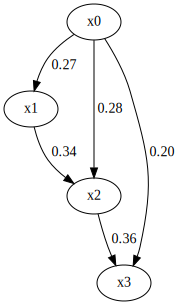

#### t=1

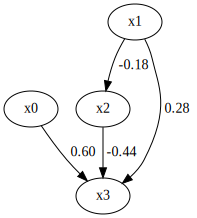

#### t=2

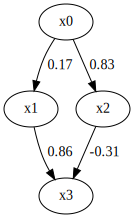

#### t=3

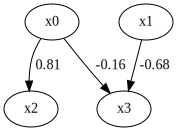

In [2]:
n_lags = 2
display(Markdown(f"### n_lags={n_lags}"))

X, B, causal_orders, es = make_data_set(n_lags=n_lags, obs_duration=4, n_features=4)

for t, b in enumerate(B[:, 0]):
    display(Markdown(f"#### t={t}"))
    display(lingam.utils.make_dot(b))

In [3]:
# 事前知識の作成
pk = np.ones((4, 4, 4)) * -1
print(pk.shape)

#　0と1は与えたところで推定には使われない。
t = 0
pk[t][ 1, 0] = 0 # 元々存在するパスを消す
pk[t][ 3, 0] = 1 # 元々存在するパスを強制

t = 1
pk[t][0, 1] = 0 # 元々存在しないパスを消す
pk[t][0, 2] = 1 # 元々存在しないパスを強制

t = 2
pk[t][1, 0] = 0 # 元々存在するパスを消す
pk[t][3, 0] = 1 # 元々存在するパスを強制

t = 3
pk[t][0, 1] = 0 # 元々存在しないパスを消す
pk[t][3, 2] = 1 # 元々存在しないパスを強制

(4, 4, 4)


(2, 4, 8)


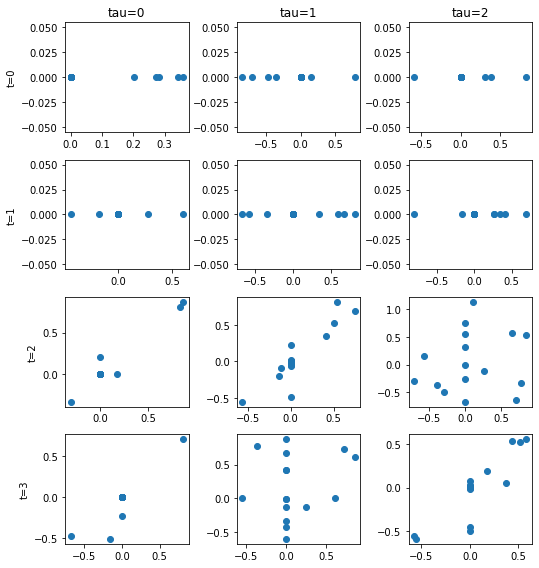

In [4]:
model = lingam.LongitudinalLiNGAM(n_lags=n_lags, prior_knowledge=pk)
model.fit(X)

# 誤りを強制した部分もあるので誤るようになる。
show_scatter(model.adjacency_matrices_, B)

#### t=0

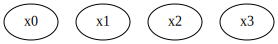

#### t=1

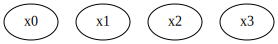

#### t=2

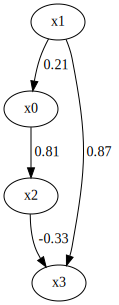

#### t=3

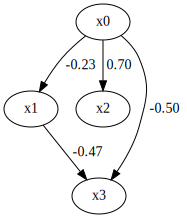

In [5]:
for t, b in enumerate(model.adjacency_matrices_[:, 0]):
    display(Markdown(f"#### t={t}"))
    display(lingam.utils.make_dot(b))

## 結果
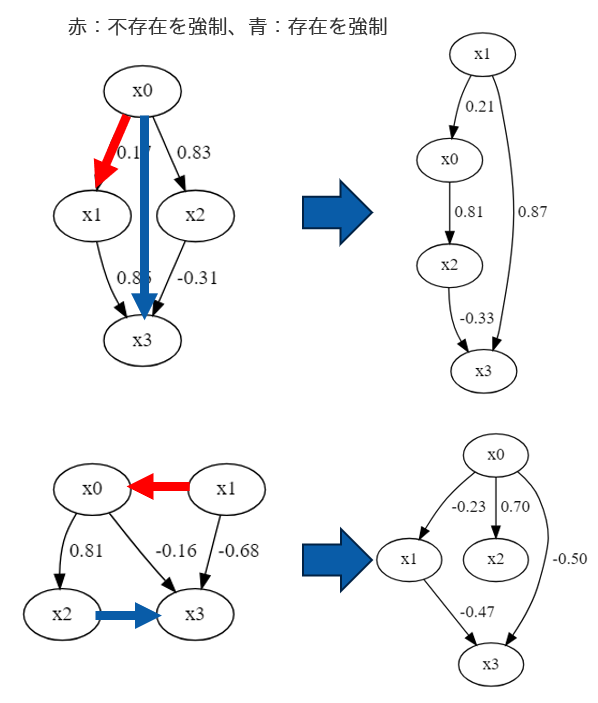

x2 -> x3を持たなかった。